In [113]:
import pandas as pd
import numpy as np
import os
import joblib
import re


from plotnine import ggplot, aes, geoms, scales, position_dodge,ylab,xlab
from plotnine import theme, element_blank,element_line,element_rect,element_text, ylim, xlim, annotate, ggtitle,coord_flip

In [7]:
results = pd.read_csv('Results/classification_results_with_coefs.csv')

with open('Results/Official_TopicModel_80k.pkl', 'rb') as File:
    Models = joblib.load(File)
    
mapper = Models['mapper']
mapper['year'] = pd.to_numeric(mapper['year'])

## speech models

In [144]:
def make_plot(year,type='speaker_accuracy'):
    
    # get the classification results row
    coefs = results.loc[results.year == year]
    
    # get accuracy value
    speaker_acc = coefs[type].values[0]
    
    # coefficients for model
    if type == 'speaker_accuracy':
        coefs = coefs['speaker_acc_coef'].values[0]
    else: 
        coefs = coefs['speech_acc_coef'].values[0]
        
    # string format coeficients into numpy array
    coefs = np.fromstring(coefs.strip('[]'), dtype=float, sep=' ')

    # prepare coeficient DF for plotting
    coef_df = pd.DataFrame({"coefs":coefs,"topic_id":range(len(coefs)),'year':year}).sort_values('coefs',ascending=False)
    coef_df = coef_df.merge(mapper,on=['year','topic_id'],how='left')
    
    # assign party based on > 0
    coef_df['party'] = coef_df.coefs.apply(lambda x: 'Dem' if x > 0 else 'Rep')
    coef_df['inverse_coef'] = 0-coef_df['coefs'] # flip coef for left-right

    # assign duplicate label names
    new_labels = []
    tracker = []
    for coef in coef_df['dynamic_label']:
        if coef not in tracker:
            new_labels.append(coef)
        else:
            new_labels.append(f"{coef}_{len([i for i in tracker if i == coef]) + 1}")
        tracker.append(coef)

    coef_df['new_labels'] = new_labels
    coef_df['new_labels'] = pd.Categorical(coef_df['new_labels'], categories=new_labels)

    
    # plot
    return (
        ggplot(coef_df.loc[((coef_df.coefs > 1) | (coef_df.coefs < -1)) & (-coef_df.dynamic_label.isin(['NA','procedural']))],
               aes(x = 'new_labels',y='inverse_coef',color='party')) + 
        geoms.geom_point(size=2) + 
        geoms.geom_segment( aes(x='new_labels', xend='new_labels', y=0, yend='inverse_coef'),color='grey') + 
        coord_flip() + 
        scales.scale_color_manual(values=['blue','red'],guide=False) + 
        theme(panel_background=element_blank()) + 
        xlab('Agenda Topic') + 
        ylab('coefficient') + 
        ggtitle(f'Important Agenda Topics Contributing to {type} ({np.round(speaker_acc*100,2)}%) - {year}')
    )

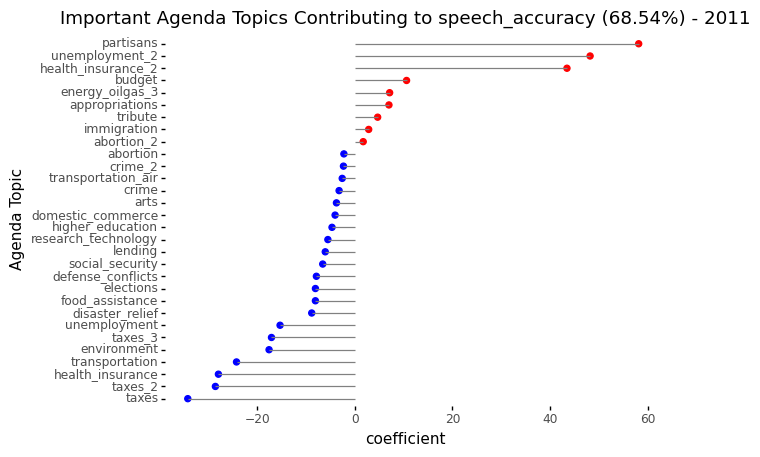

<ggplot: (8742077471394)>

In [151]:
make_plot(2011,'speech_accuracy')

In [119]:
coefs

,Unnamed: 0,year,speaker_accuracy,speaker_acc_C,speaker_acc_coef,speech_accuracy,speech_acc_C,speech_acc_coef
11,11,1994,0.708995,0.8,[[-10.20635894 -4.12972072 0. -1.7...,0.608672,0.7,[[ -6.7326797 -4.02749875 0. -1.4...


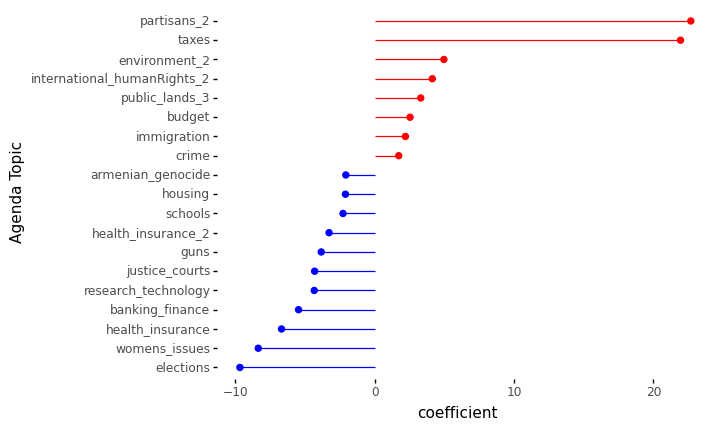

<ggplot: (-9223363294778441882)>

In [115]:
(
    ggplot(coef_df.loc[((coef_df.coefs > 1) | (coef_df.coefs < -1)) & (-coef_df.dynamic_label.isin(['NA','procedural']))],
           aes(x = 'new_labels',y='inverse_coef',color='party')) + 
    geoms.geom_point(size=2) + 
    geoms.geom_segment( aes(x='new_labels', xend='new_labels', y=0, yend='inverse_coef')) + 
    coord_flip() + 
    scales.scale_color_manual(values=['blue','red'],guide=False) + 
    theme(panel_background=element_blank()) + 
    xlab('Agenda Topic') + 
    ylab('coefficient')
)